# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Handling timestamps'''
import datetime
from datetime import datetime

In [3]:
# url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

# data = pd.read_csv(url)
# # Dataset is now stored in a Pandas Dataframe
# data = data.drop(columns="Unnamed: 0").set_index("date")

In [4]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [5]:
data = pd.read_csv("../data/BTC4h.csv")

In [6]:
def get_new_data():
    data = pd.read_csv("../data/BTC4h.csv")
    data['date'] = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

data = get_new_data()

In [8]:
CLOSE = 'log_close'

In [9]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change()
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    data['perc_bb'] = (data[CLOSE] - data['bollinger_down']) / (data['bollinger_up'] - data['bollinger_down'])

    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [10]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

### Daily return

$ return = \frac{new - old}{old} $

In [11]:
data = feature_engineer(data)

In [12]:
data = data.dropna()

In [13]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,
2015-10-13 20:00:00,250.35,250.42,250.00,250.42,4.212360,5.522860,5.523140,5.521461,5.523140,5.517817,...,5.529435,5.497779,-0.006295,0.025361,1.008111,0.000051,0.000280,0.031656,43.358767,0.801141
2015-10-14 00:00:00,250.42,251.08,250.42,251.00,13.965352,5.523140,5.525772,5.523140,5.525453,5.518997,...,5.530550,5.498932,-0.005097,0.026521,2.315327,0.000419,0.002313,0.031618,41.877594,0.838801
2015-10-14 04:00:00,251.00,251.00,250.70,251.00,12.449493,5.525453,5.525453,5.524257,5.525453,5.519993,...,5.531692,5.499680,-0.006239,0.025773,-0.108544,0.000000,0.000000,0.032012,43.412828,0.805103
2015-10-14 08:00:00,251.00,251.86,251.00,251.15,8.686492,5.525453,5.528873,5.525453,5.526050,5.520928,...,5.532699,5.500623,-0.006649,0.025428,-0.302261,0.000108,0.000597,0.032077,49.118346,0.792714
2015-10-14 12:00:00,251.15,253.00,251.15,253.00,2.049007,5.526050,5.533389,5.526050,5.533389,5.522850,...,5.534945,5.501061,-0.001556,0.032329,-0.764116,0.001328,0.007339,0.033885,59.940756,0.954085


## BITCOIN Price

In [14]:
import seaborn as sns

In [15]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'stoch_rsi', 'perc_bb'],
      dtype='object')

In [16]:
data.corr()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi,perc_bb
open,1.000000,0.999861,0.999735,0.999701,-0.044233,0.770054,0.770039,0.769864,0.769972,0.769700,...,0.769038,0.769054,-0.106494,0.129352,-0.012639,-0.012805,-0.010607,0.172846,0.000564,-0.021310
high,0.999861,1.000000,0.999672,0.999855,-0.040998,0.769857,0.769960,0.769686,0.769874,0.769540,...,0.768976,0.768802,-0.107382,0.133206,-0.012612,-0.005775,-0.002402,0.176303,0.001219,-0.019001
low,0.999735,0.999672,1.000000,0.999797,-0.050336,0.770245,0.770249,0.770236,0.770283,0.769873,...,0.769057,0.769316,-0.099270,0.130620,-0.012702,-0.004367,-0.000700,0.168414,0.002553,-0.016086
close,0.999701,0.999855,0.999797,1.000000,-0.045093,0.770011,0.770095,0.769942,0.770125,0.769694,...,0.769019,0.769027,-0.102232,0.133902,-0.012656,0.000999,0.005607,0.172993,0.002142,-0.015462
volume,-0.044233,-0.040998,-0.050336,-0.045093,1.000000,0.072514,0.076088,0.066920,0.071933,0.073536,...,0.084780,0.063453,-0.333019,0.223420,-0.004715,-0.044240,-0.048514,0.409000,-0.025150,-0.056741
log_open,0.770054,0.769857,0.770245,0.770011,0.072514,1.000000,0.999886,0.999922,0.999927,0.999872,...,0.999275,0.999295,-0.152312,0.153892,-0.027953,-0.016566,-0.011000,0.224616,-0.015683,-0.057229
log_high,0.770039,0.769960,0.770249,0.770095,0.076088,0.999886,1.000000,0.999816,0.999889,0.999785,...,0.999292,0.999104,-0.153690,0.157725,-0.027966,-0.010376,-0.004747,0.228421,-0.015002,-0.055214
log_low,0.769864,0.769686,0.770236,0.769942,0.066920,0.999922,0.999816,1.000000,0.999944,0.999784,...,0.999041,0.999308,-0.146078,0.153972,-0.028061,-0.008756,-0.003161,0.220055,-0.014143,-0.053174
log_close,0.769972,0.769874,0.770283,0.770125,0.071933,0.999927,0.999889,0.999944,1.000000,0.999824,...,0.999216,0.999230,-0.149042,0.157354,-0.028013,-0.004687,0.001059,0.224707,-0.014267,-0.052536
ema12,0.769700,0.769540,0.769873,0.769694,0.073536,0.999872,0.999785,0.999784,0.999824,1.000000,...,0.999568,0.999573,-0.162194,0.144261,-0.027932,-0.014531,-0.008943,0.224943,-0.024460,-0.067538


In [17]:
# TIME = 10000
# data = data[TIME:]

In [281]:
#selected_features=[CLOSE,'log_high', 'bollinger_up', 'rsi']
#21,99 emas
#selected_features=[CLOSE,'log_high','rsi','ema34', '4h Return','bollinger_up']
selected_features = [CLOSE, 'dist_bollinger_up','dist_ema200', 'rsi']

In [282]:
selected_data = data[selected_features]
selected_data

,log_close,dist_bollinger_up,dist_ema200,rsi
date,,,,
2015-10-13 20:00:00,5.523140,-0.006295,0.014260,62.190482
2015-10-14 00:00:00,5.525453,-0.005097,0.015987,64.007385
2015-10-14 04:00:00,5.525453,-0.006239,0.015435,64.007385
2015-10-14 08:00:00,5.526050,-0.006649,0.015492,64.518054
2015-10-14 12:00:00,5.533389,-0.001556,0.022080,70.125517
...,...,...,...,...
2021-08-12 04:00:00,10.720834,-0.041177,0.155998,52.791983
2021-08-12 08:00:00,10.709046,-0.047886,0.142775,48.447379
2021-08-12 12:00:00,10.696573,-0.058397,0.129006,44.293433


<AxesSubplot:>

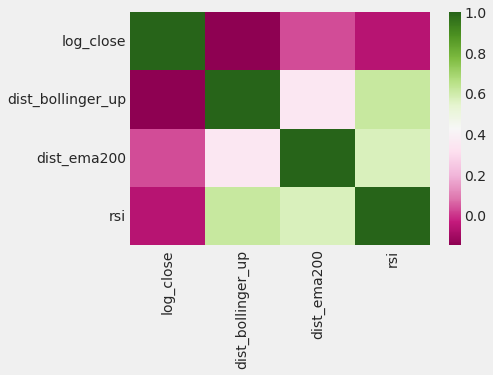

In [283]:
sns.heatmap(selected_data.corr(),cmap="PiYG")

In [284]:
len(selected_data)

12775

In [285]:
np.array(selected_data)[1][0]

5.525452939131784

In [286]:
selected_data

,log_close,dist_bollinger_up,dist_ema200,rsi
date,,,,
2015-10-13 20:00:00,5.523140,-0.006295,0.014260,62.190482
2015-10-14 00:00:00,5.525453,-0.005097,0.015987,64.007385
2015-10-14 04:00:00,5.525453,-0.006239,0.015435,64.007385
2015-10-14 08:00:00,5.526050,-0.006649,0.015492,64.518054
2015-10-14 12:00:00,5.533389,-0.001556,0.022080,70.125517
...,...,...,...,...
2021-08-12 04:00:00,10.720834,-0.041177,0.155998,52.791983
2021-08-12 08:00:00,10.709046,-0.047886,0.142775,48.447379
2021-08-12 12:00:00,10.696573,-0.058397,0.129006,44.293433


### Temporal Train-Test Split

In [287]:
train_percentage = 95

In [288]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

12136

In [289]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


## LSTM

In [290]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [291]:
minmax_scaler.data_max_

array([1.10754626e+01, 6.58308338e-02, 6.49934662e-01, 9.35903356e+01])

In [292]:
minmax_scaler.data_min_

array([ 5.52313951, -0.69775418, -0.60782465,  5.6490747 ])

In [293]:
min1 = minmax_scaler.data_min_[0]
min1

5.523139508240802

In [294]:
range1 = minmax_scaler.data_range_[0]
range1

5.552323087034936

In [295]:
data_train_scaled[:]

array([[0.00000000e+00, 9.05543040e-01, 4.94597662e-01, 6.42945155e-01],
       [4.16659992e-04, 9.07112420e-01, 4.95970516e-01, 6.63605572e-01],
       [4.16659992e-04, 9.05616435e-01, 4.95531725e-01, 6.63605572e-01],
       ...,
       [9.70733131e-01, 8.54939922e-01, 4.73019175e-01, 6.26336810e-01],
       [9.68898097e-01, 8.38649264e-01, 4.65101000e-01, 5.81984826e-01],
       [9.70825681e-01, 8.50142132e-01, 4.73706252e-01, 6.15234798e-01]])

### Creating subsequences...

In [296]:
window_size = 36  # test with small window size         #60
horizon = 3 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size:k+window_size+horizon]) #add [0] for log_price to be predicted

In [297]:
np.array(fake_y_train).shape

(12098, 3, 4)

In [298]:
np.array(data_train_subsequences).shape

(12098, 36, 4)

In [299]:
X_train = np.array(data_train_subsequences) #[:,:,1:]
y_train = np.array(fake_y_train)[:,:,0] #.reshape(-1,1)

In [300]:
X_train.shape

(12098, 36, 4)

In [301]:
y_train.shape

(12098, 3)

In [302]:
#with the same window_size & horizon as the train data
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size:k+window_size+horizon])

In [303]:
X_test = np.array(data_test_subsequences) #[:,:,1:]
y_test = np.array(fake_y_test)[:,:,0] #.reshape(-1,1)

In [304]:
X_test.shape

(601, 36, 4)

In [305]:
y_test.shape

(601, 3)

### LSTM

#### RNN Architecture

In [306]:
pd.DataFrame(y_test).shape

(601, 3)

In [307]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


In [308]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))
model.add(layers.Dropout(rate=0.05))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))
#model.add(layers.Dropout(rate=0.05))
# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))

#model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dense(16,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(8,activation="relu"))

model.add(layers.Dense(3,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [309]:
# from tensorflow.keras import Sequential, layers

# # Build the LSTM model
# model = Sequential()

# model.add(layers.LSTM(units=128,
#                      return_sequences = True,
#                      activation = "tanh"
#                     #activation = "relu"
#                      #input_shape = X_train[0].shape)
#                      ))

# model.add(layers.LSTM(units=64,
#                       return_sequences = False,
#                       activation = "relu"  
#                     #activation = "relu"
#                      ))

# # model.add(layers.Dense(25,
# #                          activation="relu"))
# model.add(layers.Dense(32,
#                         activation = "tanh" 
#                        #activation="relu"
#                       ))
# #model.add(layers.Dense(16,activation="relu"))
# model.add(layers.Dense(8,
#                        activation = "relu"
#                        #activation="relu"
#                       ))
# model.add(layers.Dense(4,
#                       activation = "relu" 
#                       #activation="relu"
#                       ))

# #model.summary()



In [310]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [311]:
#### perhaps create a validation and train sets by hand

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, 
                   restore_best_weights= True,
                   monitor = "mae"
                  )

history = model.fit(X_train, y_train,
          validation_split = 0.2,
         batch_size=16,
         epochs=30,
         verbose = 1,
         callbacks = [es]
                   )

Epoch 1/30
605/605 [==============================] - 18s 26ms/step - loss: 0.0035 - mae: 0.0219 - val_loss: 0.0018 - val_mae: 0.0281
Epoch 2/30
605/605 [==============================] - 17s 28ms/step - loss: 1.4726e-04 - mae: 0.0093 - val_loss: 0.0014 - val_mae: 0.0256
Epoch 3/30
605/605 [==============================] - 17s 29ms/step - loss: 1.1004e-04 - mae: 0.0080 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 4/30
605/605 [==============================] - 19s 31ms/step - loss: 9.0813e-05 - mae: 0.0073 - val_loss: 5.1598e-04 - val_mae: 0.0150
Epoch 5/30
605/605 [==============================] - 19s 32ms/step - loss: 9.1964e-05 - mae: 0.0073 - val_loss: 4.1006e-04 - val_mae: 0.0140
Epoch 6/30
605/605 [==============================] - 18s 30ms/step - loss: 7.5190e-05 - mae: 0.0066 - val_loss: 4.7845e-04 - val_mae: 0.0141
Epoch 7/30
605/605 [==============================] - 21s 34ms/step - loss: 1.0334e-04 - mae: 0.0078 - val_loss: 7.2907e-04 - val_mae: 0.0194
Epoch 8/30
605/605 [==

In [205]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

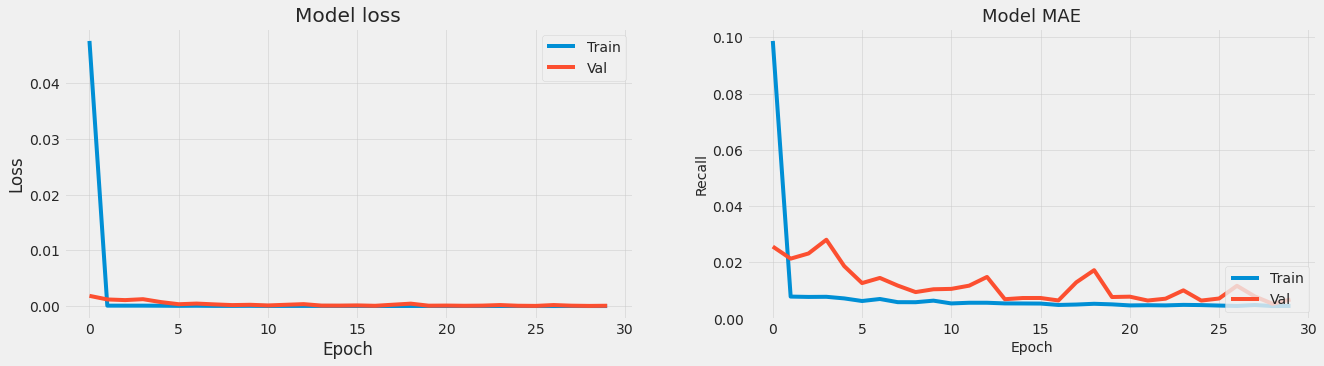

In [206]:
plot_loss_mae(history)

#### Evaluating

In [207]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


19/19 [==============================] - 0s 11ms/step - loss: 1.6403e-04 - mae: 0.0113


[0.0001640254631638527, 0.011347808875143528]

#### Predictions

In [208]:
predictions = model.predict(X_test)


In [209]:
len(predictions), len(y_test)

(601, 601)

In [210]:
predictions[0:3]

array([[0.95946556, 0.952289  , 0.95229465],
       [0.9534805 , 0.94617754, 0.9462431 ],
       [0.95575064, 0.9486739 , 0.9486632 ]], dtype=float32)

In [211]:
y_test_unscaled = y_test * range1 + min1

In [212]:
predictions_unscaled = predictions * range1 + min1

In [213]:
predictions_unscaled[0:3]

array([[10.850402, 10.810555, 10.810587],
       [10.817171, 10.776623, 10.776987],
       [10.829776, 10.790483, 10.790424]], dtype=float32)

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [214]:
X_test.shape

(601, 36, 3)

In [215]:
predictions.shape

(601, 3)

In [216]:
pred = pd.DataFrame(predictions_unscaled, columns = ['pred_1','pred_2','pred_3']) #'pred_4','pred_5','pred_6'
test = pd.DataFrame(y_test_unscaled, columns = ['test_1','test_2','test_3']) #, 'test_4','test_5','test_6'
result = pd.concat([pred, test], axis=1)

In [217]:
result

,pred_1,pred_2,pred_3,test_1,test_2,test_3
0,10.850402,10.810555,10.810587,10.894236,10.908013,10.882556
1,10.817171,10.776623,10.776987,10.908013,10.882556,10.912033
2,10.829776,10.790483,10.790424,10.882556,10.912033,10.912889
3,10.800315,10.760424,10.760653,10.912033,10.912889,10.917659
4,10.830543,10.792512,10.792070,10.912889,10.917659,10.962394
...,...,...,...,...,...,...
596,10.695477,10.663405,10.661669,10.726566,10.735267,10.720834
597,10.680655,10.647997,10.646490,10.735267,10.720834,10.709046
598,10.687410,10.655041,10.653422,10.720834,10.709046,10.696573
599,10.672697,10.639726,10.638342,10.709046,10.696573,10.701154


In [218]:
for i in range(1,4):
    result[f'weight_{i}'] = np.mean(result[f'test_{i}'] - result[f'pred_{i}'])

In [219]:
result

,pred_1,pred_2,pred_3,test_1,test_2,test_3,weight_1,weight_2,weight_3
0,10.850402,10.810555,10.810587,10.894236,10.908013,10.882556,0.043817,0.070695,0.072864
1,10.817171,10.776623,10.776987,10.908013,10.882556,10.912033,0.043817,0.070695,0.072864
2,10.829776,10.790483,10.790424,10.882556,10.912033,10.912889,0.043817,0.070695,0.072864
3,10.800315,10.760424,10.760653,10.912033,10.912889,10.917659,0.043817,0.070695,0.072864
4,10.830543,10.792512,10.792070,10.912889,10.917659,10.962394,0.043817,0.070695,0.072864
...,...,...,...,...,...,...,...,...,...
596,10.695477,10.663405,10.661669,10.726566,10.735267,10.720834,0.043817,0.070695,0.072864
597,10.680655,10.647997,10.646490,10.735267,10.720834,10.709046,0.043817,0.070695,0.072864
598,10.687410,10.655041,10.653422,10.720834,10.709046,10.696573,0.043817,0.070695,0.072864
599,10.672697,10.639726,10.638342,10.709046,10.696573,10.701154,0.043817,0.070695,0.072864


In [220]:
for i in range(1,4):
    result[f'pred_weight_{i}'] = result[f'pred_{i}'] + result[f'weight_{i}']

In [221]:
result

,pred_1,pred_2,pred_3,test_1,test_2,test_3,weight_1,weight_2,weight_3,pred_weight_1,pred_weight_2,pred_weight_3
0,10.850402,10.810555,10.810587,10.894236,10.908013,10.882556,0.043817,0.070695,0.072864,10.894219,10.881250,10.883451
1,10.817171,10.776623,10.776987,10.908013,10.882556,10.912033,0.043817,0.070695,0.072864,10.860988,10.847318,10.849851
2,10.829776,10.790483,10.790424,10.882556,10.912033,10.912889,0.043817,0.070695,0.072864,10.873592,10.861178,10.863288
3,10.800315,10.760424,10.760653,10.912033,10.912889,10.917659,0.043817,0.070695,0.072864,10.844132,10.831119,10.833516
4,10.830543,10.792512,10.792070,10.912889,10.917659,10.962394,0.043817,0.070695,0.072864,10.874359,10.863207,10.864934
...,...,...,...,...,...,...,...,...,...,...,...,...
596,10.695477,10.663405,10.661669,10.726566,10.735267,10.720834,0.043817,0.070695,0.072864,10.739293,10.734100,10.734533
597,10.680655,10.647997,10.646490,10.735267,10.720834,10.709046,0.043817,0.070695,0.072864,10.724472,10.718692,10.719354
598,10.687410,10.655041,10.653422,10.720834,10.709046,10.696573,0.043817,0.070695,0.072864,10.731227,10.725736,10.726286
599,10.672697,10.639726,10.638342,10.709046,10.696573,10.701154,0.043817,0.070695,0.072864,10.716514,10.710421,10.711206


In [222]:
# for col in ['pred_1','pred_2','pred_3','test_1','test_2','test_3']

In [223]:
# mae_1 = np.mean(np.abs(result['test_1'] - result['pred_1']))
# mae_2 = np.mean(np.abs(result['test_2'] - result['pred_2']))
# mae_3 = np.mean(np.abs(result['test_3'] - result['pred_3']))
# #mae_4 = np.mean(np.abs(result['test_4'] - result['pred_4']))

In [224]:
# #log_data
mae_1 = np.mean(np.abs(np.exp(result['test_1']) - np.exp(result['pred_1'])))
mae_2 = np.mean(np.abs(np.exp(result['test_2']) - np.exp(result['pred_2'])))
mae_3 = np.mean(np.abs(np.exp(result['test_3']) - np.exp(result['pred_3'])))
#mae_4 = np.mean(np.abs(np.exp(result['test_4']) - np.exp(result['pred_4'])))
# # #mae_5 = np.mean(np.abs(np.exp(result['test_5']) - np.exp(result['pred_5'])))
# # #mae_6 = np.mean(np.abs(np.exp(result['test_6']) - np.exp(result['pred_6'])))

In [225]:
# np.exp(result['weight_1'].mean())

In [226]:
print(mae_1)
print(mae_2)
print(mae_3)
#print(mae_4)

1771.92411358672
2761.771658173866
2841.283106671162


In [229]:
np.mean([mae_1,mae_2,mae_3])

2458.326292810583

In [230]:
mae = np.mean(np.abs(y_test_unscaled[:,0] - predictions_unscaled[:,0]))
mae

0.04451182355607836

In [231]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

0.5948548253817955

In [232]:
# df =pd.DataFrame()
# df['y_test'] = pd.DataFrame(y_test_unscaled).apply(lambda x: np.exp(x))
# df['pred'] = pd.DataFrame(predictions_unscaled).apply(lambda x: np.exp(x))
# df['diff'] = df['y_test'] - df['pred']

In [233]:
# np.mean(np.abs(df['diff']))

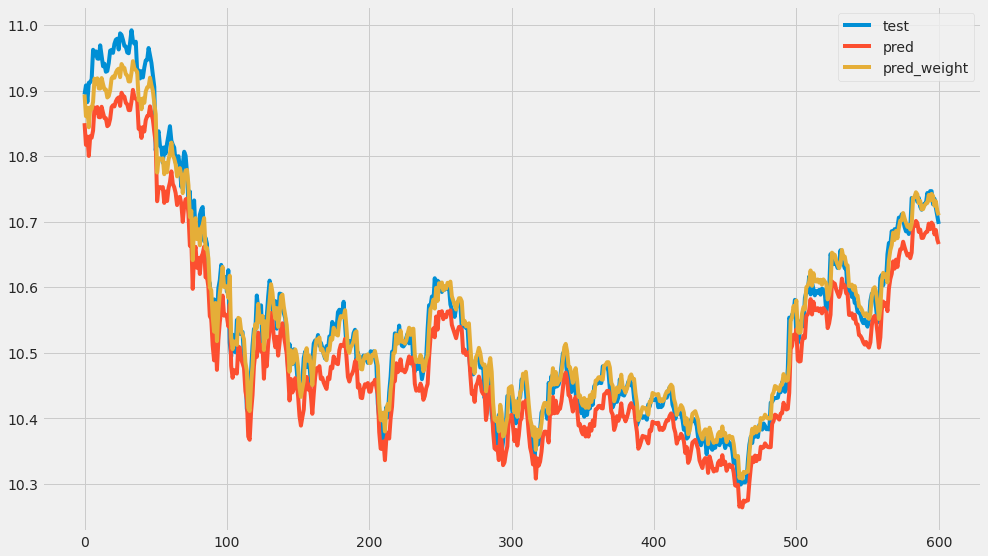

In [234]:
plt.figure(figsize=(15,9))
plt.plot(result[['test_1', 'pred_1', 'pred_weight_1']][:], label=["test", "pred", "pred_weight"])
plt.legend()                                      #timehorizon here
plt.show()


No handles with labels found to put in legend.


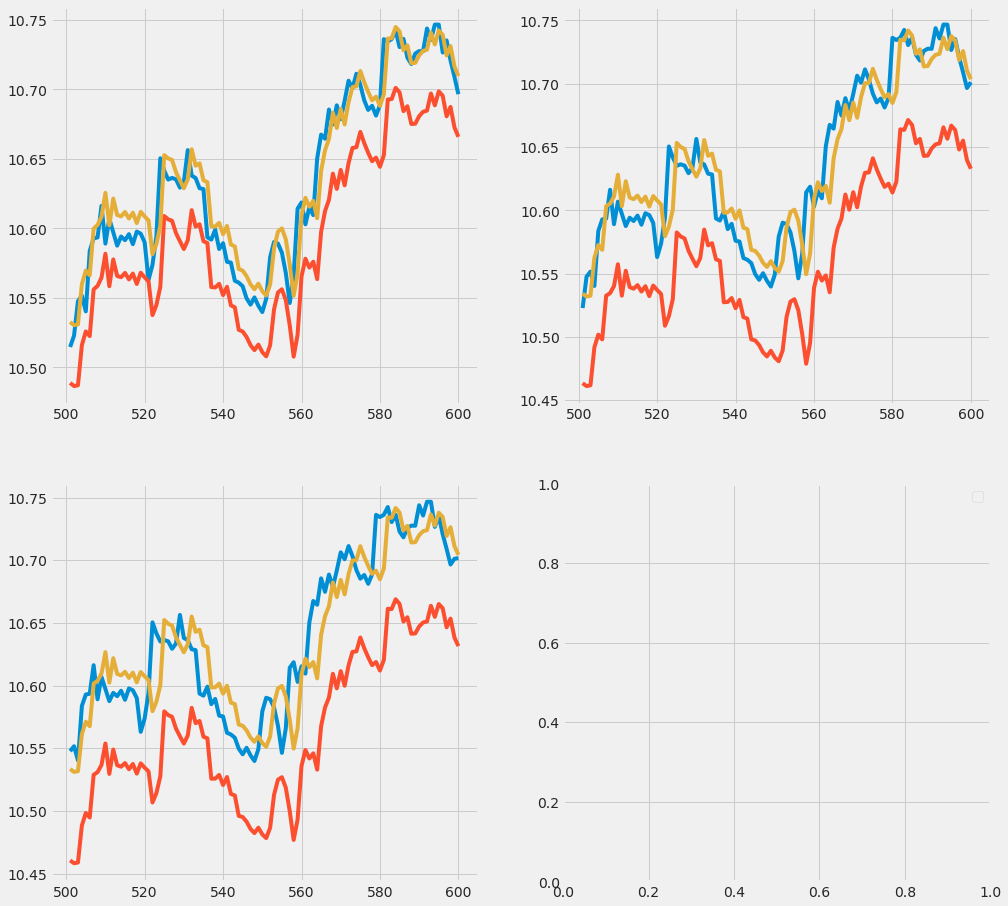

In [235]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].plot(result[['test_1', 'pred_1', 'pred_weight_1']][-100:], label=["test", "pred", "pred_weight"])
axs[0,1].plot(result[['test_2', 'pred_2', 'pred_weight_2']][-100:], label=["test", "pred", "pred_weight"])
axs[1,0].plot(result[['test_3', 'pred_3', 'pred_weight_3']][-100:], label=["test", "pred", "pred_weight"])
#axs[1,1].plot(result[['test_4', 'pred_4', 'pred_weight_4']][-100:], label=["test", "pred", "pred_weight"])

plt.legend()
plt.show()


# PREDICTION WITH COINGECKO!!!

In [236]:
gecko_api = get_coingecko()

In [237]:
coingecko = feature_engineer(gecko_api)
coingecko['perc_bb'] = (coingecko.log_close - coingecko.bollinger_down) / (coingecko.bollinger_up - coingecko.bollinger_down)
coingecko = coingecko[selected_features][-160:]

In [238]:
x_gecko_scaled = minmax_scaler.transform(coingecko)

In [239]:
# x_gecko_subsequences = []
# for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
#     x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [240]:
# x_gecko = np.array(x_gecko_subsequences)

In [241]:
x_gecko_scaled.shape

(160, 3)

In [242]:
x_gecko = x_gecko_scaled[-window_size:]

In [243]:
x_gecko.shape

(36, 3)

In [244]:
x_gecko = np.array(x_gecko).reshape(-1,window_size,len(selected_features))

In [245]:
x_gecko.shape

(1, 36, 3)

In [246]:
pred_gecko = model.predict(x_gecko)

In [247]:
pred_gecko_unscaled = pred_gecko * range1 + min1

In [248]:
pred_gecko_unscaled

array([[10.700921, 10.667088, 10.665859]], dtype=float32)

In [249]:
#weighted prediction

In [250]:
weighted_pred = []
for i in range(0,3):
    weighted_pred.append(pred_gecko_unscaled[0][i] + result[f'weight_{i+1}'].mean())

In [251]:
#log
# weighted_pred = []
# for i in range(0,4):
#     weighted_pred.append(np.exp(pred_gecko_unscaled[0][i] + result[f'weight_{i+1}'].mean()))

In [252]:
weighted_pred

[10.744737725203432, 10.73778243383949, 10.738723032028458]

In [253]:
#add mae
mae_1
mae_2
mae_3
#mae_4

2841.283106671162

In [254]:
mae_list = [mae_1, mae_2, mae_3]
preds = list(pred_gecko_unscaled[0])

In [255]:
#log
# mae_list = [mae_1, mae_2, mae_3, mae_4]
# preds = list(np.exp(pred_gecko_unscaled[0]))

In [256]:
preds_with_mae = [a+b for a,b in zip(mae_list, preds)]

In [257]:
preds_with_mae

[1782.6250346453749, 2772.4387457287976, 2851.948965893574]

In [258]:
#pred_weighted = pred_gecko_unscaled[0][0] + weight

In [259]:
#np.exp(pred_weighted)

In [260]:
np.exp(pred_gecko_unscaled)

array([[44396.73 , 42919.758, 42867.07 ]], dtype=float32)

In [261]:
##########

In [262]:
pred_weighted = pred_gecko_unscaled + weight

NameError: name 'weight' is not defined

In [263]:
df = coingecko[[CLOSE]].reset_index(drop=True) #.apply(lambda x: np.exp(x))

In [264]:
#df1 = pd.DataFrame(pred_gecko_unscaled.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [265]:
#df1 = pd.DataFrame(weighted_pred.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [266]:
df1 = pd.DataFrame(np.array(weighted_pred).reshape(3,1),columns=[CLOSE])

In [267]:
#df1 = pd.DataFrame(np.array(preds_with_mae).reshape(4,1),columns=[CLOSE])

In [275]:
df2 = pd.concat([df,df1],axis=0).reset_index(drop=True).apply(lambda x: np.exp(x))
df2

,log_close
0,40927.230000
1,40339.040000
2,40959.430000
3,40763.040000
4,40846.920000
...,...
158,47410.510000
159,47588.380000
160,46385.292928
161,46063.789073


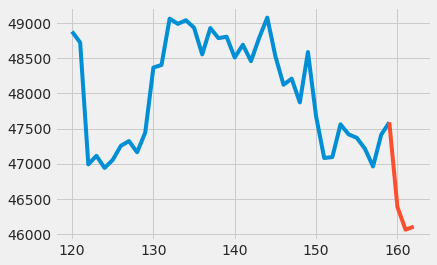

In [277]:
plt.plot(df2[120:160])
plt.plot(df2[159:])


In [ ]:
from tensorflow.keras.models import save_model
save_model(model, 'tensorflowmodel')

In [ ]:
x_gecko_scaled
x_gecko_subsequences = []
for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
    x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
#x_gecko = np.array(x_gecko)
x_gecko = np.reshape(x_gecko, (-1,window_size,len(selected_features))) #[-horizon:,:,:]

x_gecko.shape

In [ ]:
predictions = model.predict(x_gecko)

predictions

In [ ]:
predictions_unscaled = predictions * range1 + min1

In [ ]:
#np.exp(predictions_unscaled)

In [ ]:
from datetime import datetime
dateTimeObj = datetime.now()
print(dateTimeObj)

In [ ]:
close = pd.DataFrame(coingecko.close[-10:].reset_index().drop(columns='index'))

In [ ]:
close

In [ ]:
for i in range(len(close),len(close) + horizon):
    print(i)

In [ ]:
pred = pd.DataFrame(np.exp(predictions_unscaled), columns = ['close']).set_index(pd.Index(range(len(close),len(close) + horizon)))

In [ ]:
df = pd.DataFrame(np.exp(predictions_unscaled), columns = ['pred'])
df['gecko'] = coingecko['log_close']
df

In [ ]:
plt.plot(close)
plt.plot(pred)

In [ ]:
plt.plot(coingecko['close'][-20:])
plt.plot(predictions_unscaled)

In [ ]:
#from tensorflow.keras.models import save_model
#save_model(model, 'tensorflowmodel')